In [278]:
import pandas as pd
import numpy as np
from functools import lru_cache
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, root_mean_squared_error
from sklearn.decomposition import TruncatedSVD

In [279]:
# Funzione di caricamento dei dati
def load_data(url) -> pd.DataFrame:
    columns = ['user_id', 'movie_id', 'rating', 'timestamp']
    df = pd.read_csv(url, sep='\t', names=columns)
    df.drop(columns='timestamp', inplace=True)
    return df

# Funzione per la creazione della matrice User X Item
def create_user_item_matrix(df: pd.DataFrame):
    return df.pivot(index='user_id', columns='movie_id', values='rating')


In [280]:
# Funzione per trovare il miglior numero di cluster
def find_optimal_k(data: pd.DataFrame, k_min=2, k_max=10, verbose=False):
    best_k, best_score = k_min, -1
    for k in range(k_min, k_max+1):
        km    = KMeans(n_clusters=k, random_state=42).fit(data)
        score = silhouette_score(data, km.labels_)
        if verbose:
            print(f"k={k:2d} - silhouette={score:.3f}")
        if score > best_score:
            best_k, best_score = k, score
    print(f"Miglior k: {best_k} (silhouette={best_score:.3f})")
    return best_k

def cluster_users(data, n_clusters):
    km     = KMeans(n_clusters=n_clusters, random_state=42).fit(data)
    labels = km.labels_
    return labels, km


In [281]:
def show_cluster(data: pd.DataFrame):
    X = data.drop('cluster', axis=1).values
    y = data['cluster'].values

    # Riduzione con PCA
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)

    # Scatter plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.6)
    plt.legend(*scatter.legend_elements(), title="Cluster")
    plt.title("Utenti proiettati su PCA 2D")
    # plt.xlabel("PC1")
    # plt.ylabel("PC2")


In [282]:
@lru_cache(maxsize=1)
def load_movies(path="../datasets/ml-100k/u.item"):
    """Carica e indicizza il dataset dei film UNA volta sola."""
    cols = ["movie_id", "title", "release_date", "video_release_date", "IMDb_URL",
            "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
            "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
            "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
    df = pd.read_csv(path, sep="|", encoding="latin-1", names=cols)
    return df.set_index("movie_id")

def get_item_title(rec):
    """Ritorna i titoli per una lista di movie_id in modo vettoriale."""
    movies = load_movies()
    # movies.loc[rec, 'title'] già restituisce una Series nell'ordine di rec
    return movies.loc[rec, "title"].tolist()

In [283]:
def find_similar_user(users: pd.DataFrame, user_id: int) -> pd.Series:
    """Calcola la similarità coseno tra tutti gli utenti e ritorna la serie ordinata."""
    # users.index -> array di user_id
    mat = users.values
    sims = cosine_similarity(mat)
    # prendo la riga corrispondente a user_id
    i = users.index.get_loc(user_id)
    sim_series = pd.Series(sims[i], index=users.index)
    return sim_series.drop(user_id).sort_values(ascending=False)

def predict_rating(ui_matrix: pd.DataFrame, user_id: int, item_id: int, sims: pd.Series, k_sim: int = None, verbose: bool = False) -> float:
    """
    Predice il rating per user_id–item_id:
      - se l'item non esiste: media dell'utente o globale;
      - altrimenti media pesata dei k_sim più simili nel suo cluster.
    """
    # ITEM nuovo -> fallback su media dell'utente / globale
    if item_id not in ui_matrix.columns:
        user_row = ui_matrix.loc[user_id].replace(0, np.nan)
        user_mean = user_row.mean()
        return user_mean if not np.isnan(user_mean) else ui_matrix.replace(0, np.nan).values.mean()

    # Similarità e top-k
    if k_sim:
        sims = sims.head(k_sim)

    # Prendi solo chi ha valutato item_id
    ratings = ui_matrix.loc[sims.index, item_id]
    mask = ratings > 0
    if not mask.any():
        # nessuno ha votato -> media globale dei voti non-zero su quell'item
        col = ui_matrix[item_id]
        return col[col > 0].mean()

    # media pesata con controllo divisione per zero
    weighted_sum = (sims[mask] * ratings[mask]).sum()
    sim_sum = sims[mask].sum()

    if sim_sum == 0.0:
        return 0
    return weighted_sum / sim_sum



def recommend_top_n(ui_matrix: pd.DataFrame, sims:pd.Series, user_id: int, num_recommendations: int = 5, k_sim: int = None) -> list:
    """
    Ritorna la lista dei top-N item consigliati (non ancora valutati da user_id).
    """
    user_ratings = ui_matrix.loc[user_id]
    unrated = user_ratings[user_ratings == 0].index  # item_id con rating==0

    # dict comprehension + predict_rating
    preds = {
        item: predict_rating(ui_matrix, user_id, item, sims, k_sim)
        for item in unrated
    }
    # prendi i num_recommendations con rating più alto
    
    top_items = sorted(preds, key=preds.get, reverse=True)[:num_recommendations]
    return top_items

In [284]:
def evaluate_rating_pred(ui_matrix, test_df: pd.DataFrame, similarity_users: dict, threshold = 4):
    y_true, y_pred = [], []

    # Estraiamo le colonne di interesse e itteriamo con itertuples
    cols = ['user_id', 'movie_id', 'rating']
    total = len(test_df)
    for uid, mid, r in tqdm(test_df[cols].itertuples(index=False, name=None), total=total, 
                            desc="Evaluating ratings", unit="row", ncols=80, mininterval=0.5):
        uid, mid, r = int(uid), int(mid), float(r)
        pred_rating = predict_rating(ui_matrix=ui_matrix, user_id=uid, item_id=mid, sims=similarity_users[uid])
        
        y_true.append(r)
        y_pred.append(pred_rating)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calcolo diretto di RMSE e MAE
    y_true_binary = (y_true >= threshold).astype(int)
    y_pred_binary = (y_pred >= threshold).astype(int)
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)

    rmse = root_mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)

    print(f'Evaluation of rating prediction (threshold:{threshold})')
    print(f'MAE {mae:.4f} | RMSE {rmse:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')


In [285]:
def precision_at_k(ranked_list, ground_truth, k):
    # Precision@k: fra i primi k, quanti sono rilevanti?
    top_k = ranked_list[:k]
    return len(set(top_k) & set(ground_truth)) / k

def recall_at_k(ranked_list, ground_truth, k):
    # Recall@k: quale frazione del ground_truth è nei primi k?
    top_k = ranked_list[:k]
    return len(set(top_k) & set(ground_truth)) / len(ground_truth)

def ndcg_at_k(ranked_list, ground_truth, k):
    # NDCG@k con labels binarie (1=relevant,0=non).
    dcg = 0.0
    idcg = sum(1.0 / np.log2(i+2) for i in range(min(len(ground_truth), k)))
    for i, item in enumerate(ranked_list[:k]):
        if item in ground_truth:
            dcg += 1.0 / np.log2(i+2)
    return dcg / idcg if idcg > 0 else 0.0

def evaluate_top_n(ui_matrix: pd.DataFrame,
                   test_df: pd.DataFrame,
                   similarity_users: dict,
                   N: int = 10,
                   threshold: float = 4.0):
    # filtro il test set
    test_df = test_df[test_df['rating'] >= threshold]
    
    # true items per utente
    true_items = test_df.groupby('user_id')['movie_id'].apply(list).to_dict()
    print(f"Numero utenti con rating ≥ {threshold}: {len(true_items)}")

    # 1) Generazione predizioni
    pred_scores = {}
    users = test_df['user_id'].unique()
    for u in tqdm(users, desc="Generazione recommendations", unit="user"):
        pred_scores[int(u)] = recommend_top_n(
            ui_matrix=ui_matrix,
            sims=similarity_users[u],
            user_id=u,
            num_recommendations=N
        )
    print(pred_scores)
    # 2) Calcolo metriche
    prec_k, rec_k, ndcg_k = [], [], []
    for u in tqdm(pred_scores.keys(), desc="Calcolo metriche", unit="user"):
        ranked_list = pred_scores[u]
        gt = true_items.get(u, [])
        if not gt:
            continue
        prec_k.append(precision_at_k(ranked_list, gt, N))
        rec_k.append(recall_at_k(ranked_list, gt, N))
        ndcg_k.append(ndcg_at_k(ranked_list, gt, N))

    # risultati aggregati
    print(f"\nPrecision@{N}: {np.mean(prec_k):.4f}")
    print(f"Recall@{N}:    {np.mean(rec_k):.4f}")
    print(f"NDCG@{N}:      {np.mean(ndcg_k):.4f}")

Numero utenti: 943, Numero item: 1650
Ratings non nulli: 80000
Sparsità: 94.86%
Numero ottimale di componenti k: 244
Varianza spiegata cumulata con 244 componenti: 85.04%
(943, 244)
Miglior k: 2 (silhouette=0.289)


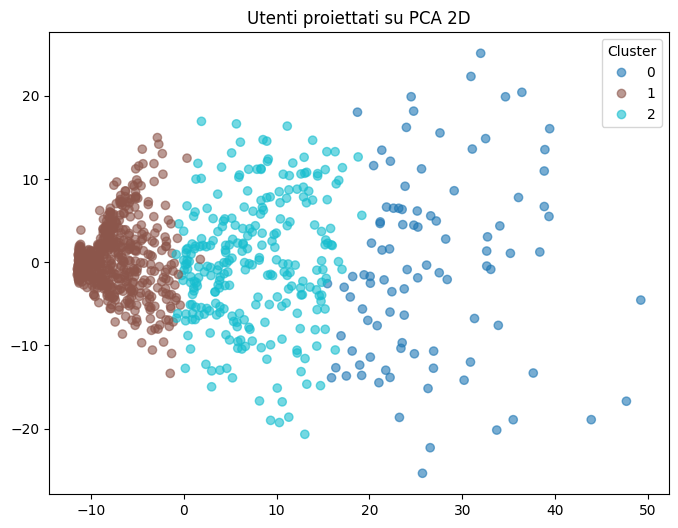

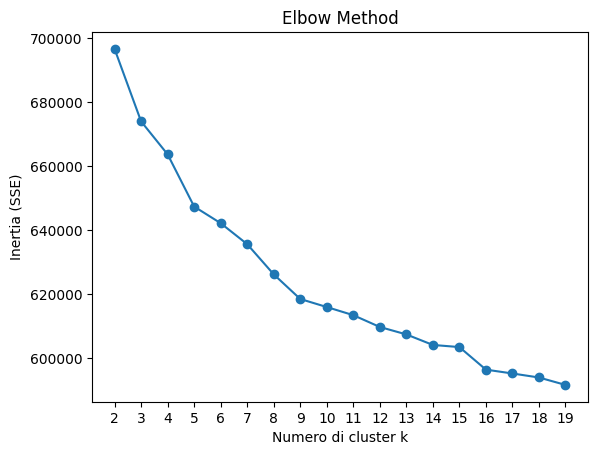

In [288]:

# Caricamento del dataset
train = load_data('../datasets/ml-100k/u1.base')
test = load_data('../datasets/ml-100k/u1.test')

# Crea la matrice user-item
ui_matrix = create_user_item_matrix(train)
n_users, n_items = ui_matrix.shape
nnz = ui_matrix.count().sum()
sparsity = 1 - nnz / (n_users * n_items)
print(f"Numero utenti: {n_users}, Numero item: {n_items}")
print(f"Ratings non nulli: {nnz}")
print(f"Sparsità: {sparsity:.2%}")

ui_matrix = ui_matrix.fillna(0)

# threshold di varianza cumulata da spiegare
threshold_variance = 0.85

# inizializziamo una SVD “completa” con il massimo numero di componenti utile
max_components = min(n_users, n_items) - 1
svd_full = TruncatedSVD(n_components=max_components, random_state=42)
svd_full.fit(ui_matrix)

# calcoliamo la varianza spiegata cumulata
cum_var = np.cumsum(svd_full.explained_variance_ratio_)

# troviamo il più piccolo k tale che cum_var[k-1] >= threshold_variance
k_opt = np.searchsorted(cum_var, threshold_variance) + 1
print(f"Numero ottimale di componenti k: {k_opt}")
print(f"Varianza spiegata cumulata con {k_opt} componenti: {cum_var[k_opt-1]:.2%}")

# SVD “ridotta” a k_opt componenti
svd_opt = TruncatedSVD(n_components=k_opt, random_state=42)
user_latent = svd_opt.fit_transform(ui_matrix)
print(user_latent.shape)
# (opzionale) ricostruzione approssimata della matrice user–item
ui_approx = pd.DataFrame(data=svd_opt.inverse_transform(user_latent), index=ui_matrix.index)

optimal_n_cluster = find_optimal_k(user_latent)
user_cluster, _ = cluster_users(user_latent, 3)
clusters = pd.Series(user_cluster, index=ui_matrix.index, name='cluster')
ui_matrix['cluster'] = clusters
show_cluster(ui_matrix)
similar_user = {}
for user in test['user_id'].unique():
    cluster_id = ui_matrix.at[user, 'cluster']
    group = ui_matrix[ui_matrix['cluster'] == cluster_id].drop(columns='cluster')
    similar_user[int(user)] = find_similar_user(users=group, user_id=user)


ks = range(2, 20)
inertias = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(user_latent)
    inertias.append(kmeans.inertia_)

# Plot dell'elbow curve
plt.figure()
plt.plot(ks, inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Numero di cluster k')
plt.ylabel('Inertia (SSE)')
plt.xticks(ks)
plt.show()

In [289]:
evaluate_top_n(ui_matrix=ui_matrix, test_df=test, N=10, similarity_users=similar_user)

Numero utenti con rating ≥ 4.0: 456


Generazione recommendations: 100%|██████████| 456/456 [04:17<00:00,  1.77user/s]


{1: [1298, 793, 850, 851, 884, 935, 1122, 1158, 1189, 1201], 2: [320, 522, 35, 74, 78, 84, 102, 140, 417, 422], 3: [522, 27, 35, 74, 78, 84, 371, 392, 489, 583], 4: [320, 606, 1154, 1293, 371, 485, 489, 521, 522, 583], 5: [119, 793, 850, 851, 884, 906, 935, 1122, 1158, 1189], 6: [119, 793, 850, 851, 884, 906, 935, 1158, 1189, 1201], 7: [1122, 1189, 1201, 1293, 1368, 1467, 1500, 1512, 1599, 1643], 8: [320, 371, 522, 863, 35, 74, 78, 84, 102, 140], 9: [320, 522, 35, 74, 78, 84, 102, 140, 422, 543], 10: [1262, 119, 793, 850, 884, 906, 935, 1122, 1189, 1201], 11: [1466, 1628, 1642, 119, 793, 850, 851, 884, 906, 935], 12: [583, 664, 960, 35, 74, 78, 84, 320, 658, 761], 13: [1122, 1189, 1201, 1293, 1368, 1467, 1500, 1512, 1599, 1643], 14: [102, 140, 422, 74, 371, 583, 658, 776, 812, 853], 15: [776, 35, 74, 78, 84, 102, 140, 320, 422, 489], 16: [119, 793, 850, 851, 884, 906, 935, 1122, 1158, 1189], 17: [320, 35, 74, 78, 84, 522, 583, 658, 664, 776], 18: [1262, 119, 793, 850, 851, 884, 906, 93

Calcolo metriche: 100%|██████████| 456/456 [00:00<00:00, 50545.80user/s]


Precision@10: 0.0022
Recall@10:    0.0011
NDCG@10:      0.0031


In [ ]:
evaluate_rating_pred(ui_matrix=ui_matrix, test_df=test, similarity_users=similar_user)

Evaluating ratings: 100%|██████████████| 20000/20000 [00:07<00:00, 2823.44row/s]

Evaluation of rating prediction (threshold:4)
MAE 0.8431 | RMSE 1.0594
Accuracy: 0.5501
Precision: 0.7836
Recall: 0.2749
